**THIS IS NOT FINANCIAL ADVICE. DO YOUR OWN RESEARCH. USE AT YOUR OWN RISK.**

In [1]:
# Parameters
# TODO Allow caller to specify index and peers
ticker_symbol = "MSFT"

In [2]:
# Parameters
ticker_symbol = "FB"


In [3]:
import datetime
import pandas as pd
import pandas_ta as ta
import yfinance as yf
import requests_cache
import matplotlib.pyplot as plt
import mplfinance as mpf

from IPython.display import display, Markdown, Latex
from matplotlib.lines import Line2D

In [4]:
session = requests_cache.CachedSession("yfinance.cache")
session.headers["User-Agent"] = f"ta-{ticker_symbol}-notebook/1.0"

In [5]:
ticker = yf.Ticker(ticker_symbol, session=session)
ticker_short_name = ticker.info["shortName"]

In [6]:
display(Markdown(f"# Technical analysis: {ticker_short_name} ({ticker_symbol})"))

# Technical analysis: Meta Platforms, Inc. (FB)

## 0 Setup

In [7]:
today = datetime.datetime.now()

date_pattern = "%Y-%m-%d"
today_str = today.strftime(date_pattern)
date_ranges = {
    "1M": (today - datetime.timedelta(days=30)).strftime(date_pattern),
    "3M": (today - datetime.timedelta(days=90)).strftime(date_pattern),
    "6M": (today - datetime.timedelta(days=180)).strftime(date_pattern),
    "1Y": (today - datetime.timedelta(days=365)).strftime(date_pattern),
}

## 1 Load data

In [8]:
hist = ticker.history(start=date_ranges["1Y"], end=today_str)

In [9]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-27,282.529999,283.450012,268.119995,272.140015,35346200,0,0
2021-01-28,277.179993,286.790009,264.700012,265.000000,37758800,0,0
2021-01-29,265.299988,266.559998,254.850006,258.329987,30389500,0,0
2021-02-01,259.519989,264.170013,254.910004,262.010010,22914300,0,0
2021-02-02,264.000000,268.850006,263.269989,267.079987,17320800,0,0


## 2 Candlestick charts

See [Candlestick definition](https://www.investopedia.com/terms/c/candlestick.asp) for more information.

In [10]:
def plot_candlestick(rng):
    start = date_ranges[rng]
    end = today_str
    mpf.plot(
        hist[start:end],
        type="candle",
        title=f"{ticker_symbol} price, {rng}",
        ylabel="Price ($)",
        volume=True,
        ylabel_lower="Volume",
        show_nontrading=False,
        mav=(4),
        figratio=(12, 6),
        style="yahoo")

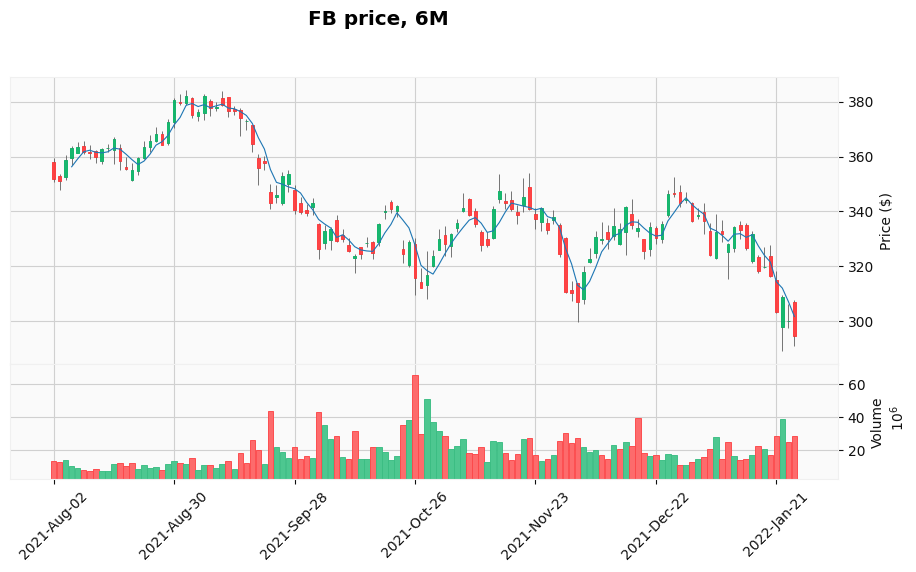

In [11]:
plot_candlestick("6M")

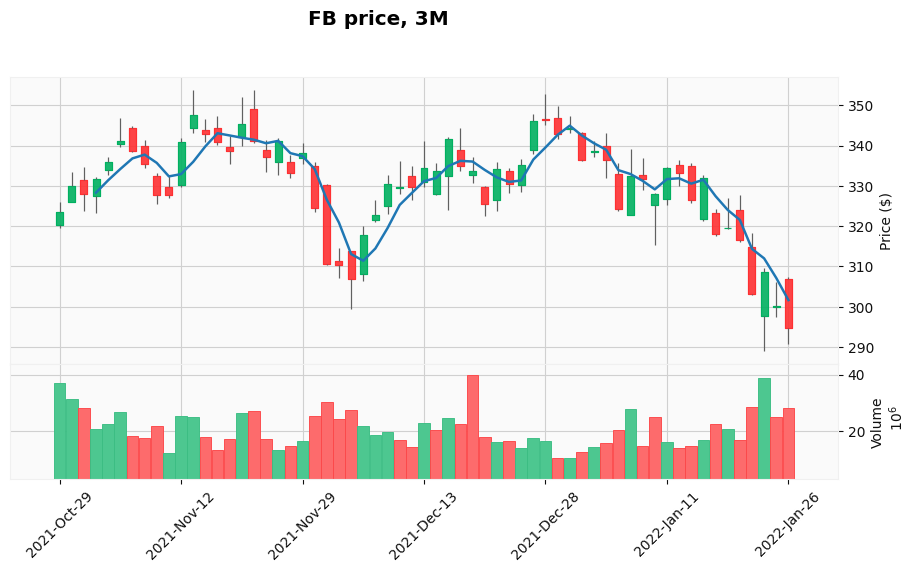

In [12]:
plot_candlestick("3M")

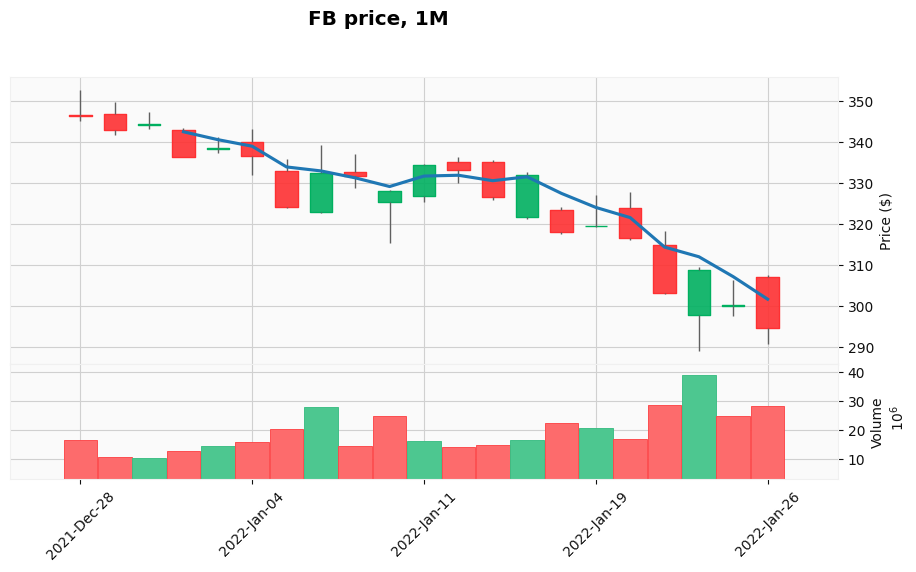

In [13]:
plot_candlestick("1M")

## 3 Capital appreciation

See [Capital Appreciation](https://www.investopedia.com/terms/c/capitalappreciation.asp) for more information.

In [14]:
# TODO Support plotting against index and also peers
def plot_capital_appreciation(rng):
    start = date_ranges[rng]
    end = today_str
    comb_df = pd.DataFrame({
        ticker_symbol: hist[start:end]["Close"],
    })
    norm_df = comb_df.div(comb_df.iloc[0])
    norm_df.plot(title=f"{ticker_symbol} capital appreciation, {rng}")

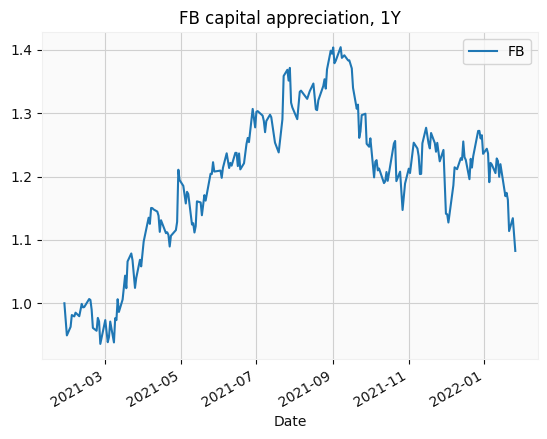

In [15]:
plot_capital_appreciation("1Y")

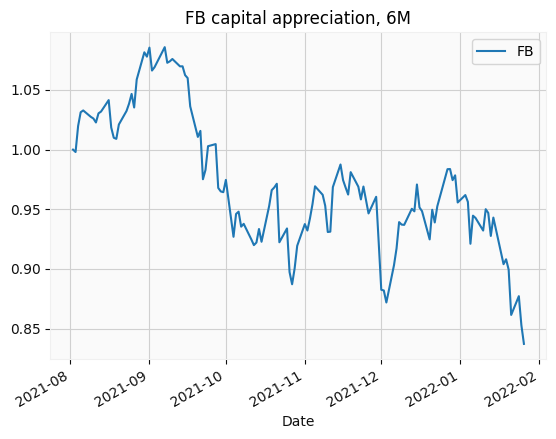

In [16]:
plot_capital_appreciation("6M")

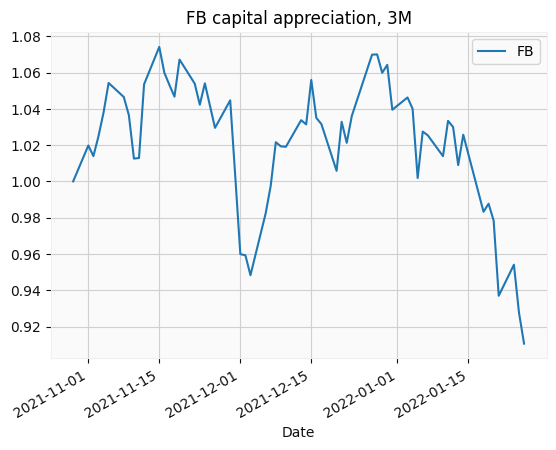

In [17]:
plot_capital_appreciation("3M")

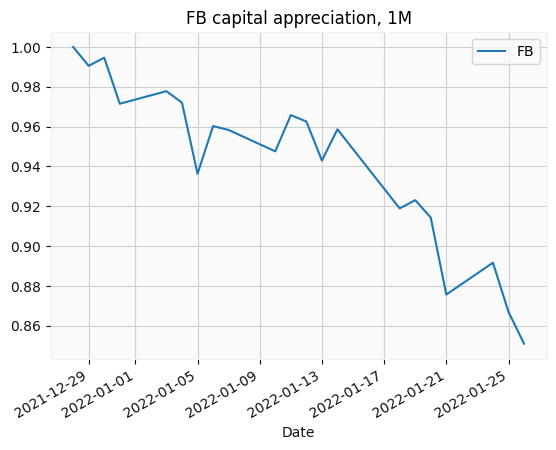

In [18]:
plot_capital_appreciation("1M")

## 4 Trend indicators

See:

- [Trend Trading](https://www.investopedia.com/terms/t/trendtrading.asp)

### 4.1 Simple Moving Average Crossover

See [How to Use a Moving Average to Buy Stocks](https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp).

In [19]:
def plot_crossover(rng):
    start = date_ranges[rng]
    end = today_str
    hist[start:end][["Close", "SMA_50", "SMA_200"]].plot(
        title=f"{ticker_symbol} SMA Crossover, {rng}",
        style=["-", "-", "--"])

In [20]:
hist["SMA_50"] = hist["Close"].rolling(50).mean()
hist["SMA_200"] = hist["Close"].rolling(200).mean()

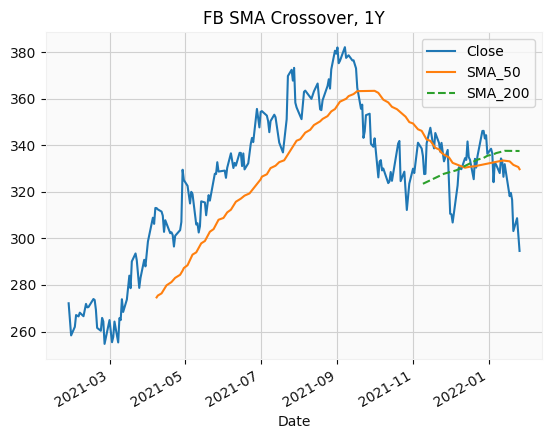

In [21]:
plot_crossover("1Y")

## 5 Volatility indicators

### 5.1 Bollinger Bands

See [Bollinger Band](https://www.investopedia.com/terms/b/bollingerbands.asp) for more information.

In [22]:
def add_bollinger_bands():
    sma_20 = hist["Close"].rolling(20)
    mean = sma_20.mean()
    two_sigmas = 2 * sma_20.std()

    hist["SMA_20"] = mean
    hist["UpperBB"] = mean + two_sigmas
    hist["LowerBB"] = mean - two_sigmas

    
def plot_bollinger(rng):
    start = date_ranges[rng]
    end = today_str
    hist[start:end][["Close", "SMA_20", "UpperBB", "LowerBB"]].plot(
        title=f"{ticker.info['symbol']} with Bollinger Bands, {rng}",
        style=["-", "--", "-", "-"])

In [23]:
add_bollinger_bands()

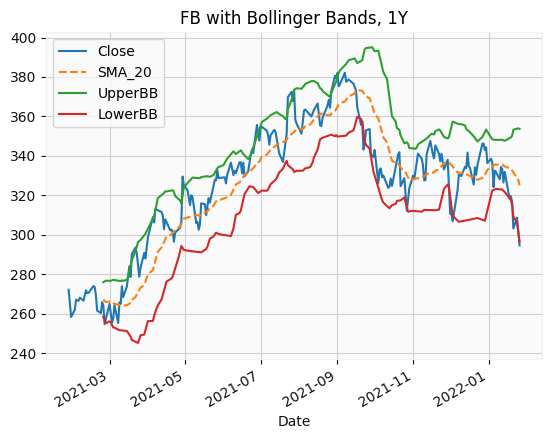

In [24]:
plot_bollinger("1Y")

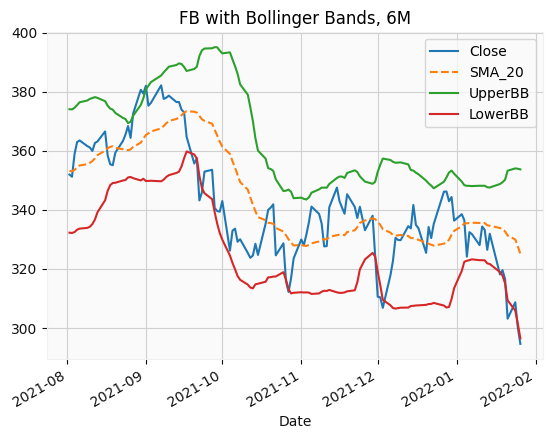

In [25]:
plot_bollinger("6M")

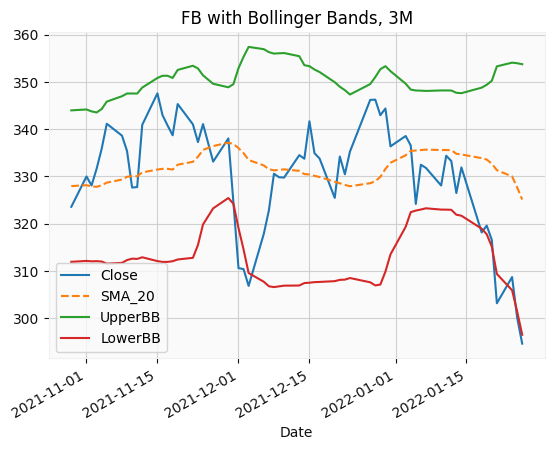

In [26]:
plot_bollinger("3M")

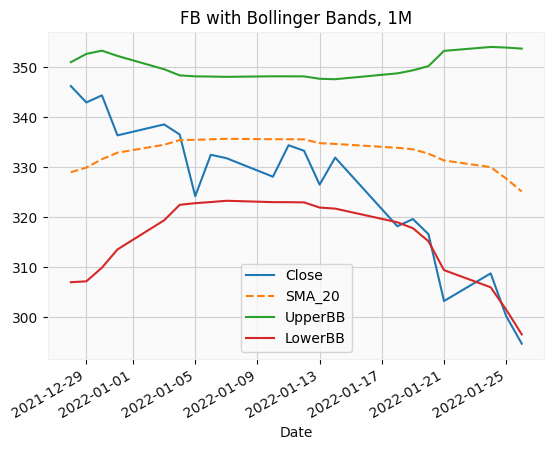

In [27]:
plot_bollinger("1M")

## 6 Momentum indicators

See [Momentum indicators](https://www.investopedia.com/investing/momentum-and-relative-strength-index/) for more information.

### 6.1 Relative Strength Index (RSI)

See [Relative Strength Index (RSI)](https://www.investopedia.com/terms/r/rsi.asp) for more information.

In [28]:
# https://www.roelpeters.be/many-ways-to-calculate-the-rsi-in-python-pandas/
def add_rsi(periods=14):
    close_diff = hist["Close"].diff()
    up = close_diff.clip(lower=0)
    down = -1 * close_diff.clip(upper=0)

    ma_up = up.ewm(com=periods-1, adjust=True, min_periods=periods).mean()
    ma_down = down.ewm(com=periods-1, adjust=True, min_periods=periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100 / (1 + rsi))
    hist["RSI"] = rsi


def plot_rsi(rng, periods=14):
    start = date_ranges[rng]
    end = today_str
    temp_df = hist[start:end]
    
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, tight_layout=True, figsize=(9, 6))

    ax[0].set_title(f"{ticker_symbol} price, {rng}")
    ax[0].plot(temp_df["Close"])

    ax[1].set_title(f"RSI ({periods}-day moving average), {rng}")
    ax[1].set_ylim(0, 100)
    ax[1].plot(temp_df["RSI"])
    ax[1].axhline(70, color="r", ls="--")
    ax[1].axhline(30, color="g", ls="--")

    custom_lines = [
        Line2D([0], [0], color="r", lw=4),
        Line2D([0], [0], color="g", lw=4)
    ]
    ax[1].legend(custom_lines, ["Overbought", "Oversold"], loc="best")

In [29]:
add_rsi()

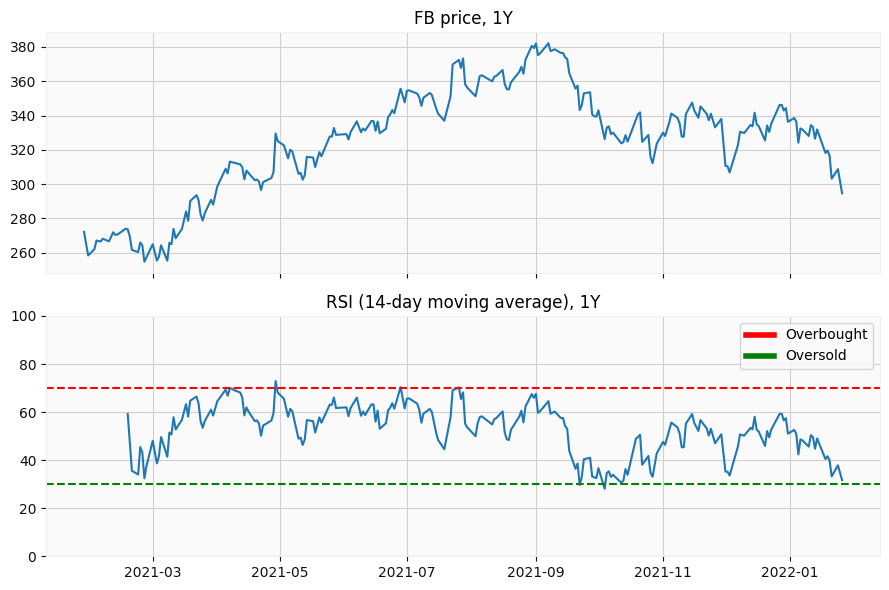

In [30]:
plot_rsi("1Y")

### 6.2 Moving Average Convergence Divergence (MACD)

See:

- [Moving Average Convergence Divergence (MACD)](https://www.investopedia.com/terms/m/macd.asp)
- [What Is the Moving Average Convergence Divergence, and How Is It Calculated?](https://www.investopedia.com/ask/answers/122414/what-moving-average-convergence-divergence-macd-formula-and-how-it-calculated.asp)
- [MACD: A Primer](https://www.investopedia.com/trading/macd/)


In [31]:
def add_macd():
    ema_12 = hist["Close"].ewm(span=12, adjust=False, min_periods=12).mean()
    ema_26 = hist["Close"].ewm(span=26, adjust=False, min_periods=26).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span=9, adjust=False, min_periods=9).mean()
    diff = macd - signal
    
    hist["MACD"] = macd
    hist["MACD-s"] = signal
    hist["MACD-h"] = diff
    

def plot_macd(rng, periods=14):
    start = date_ranges[rng]
    end = today_str
    temp_df = hist[start:end]
    
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, tight_layout=True, figsize=(9, 6))

    ax[0].set_title(f"{ticker_symbol} price, {rng}")
    ax[0].plot(temp_df["Close"])

    ax[1].set_title(f"MACD")
    ax[1].plot(temp_df["MACD"], color="dodgerblue") # slow signal
    ax[1].plot(temp_df["MACD-s"], color="orange") # fast signal
    ax[1].bar(temp_df.index, height=temp_df["MACD-h"], color="black") # diff

    custom_lines = [
        Line2D([0], [0], color="dodgerblue", lw=4),
        Line2D([0], [0], color="orange", lw=4),
        Line2D([0], [0], color="black", lw=4)
    ]
    ax[1].legend(custom_lines, ["MACD (slow)", "Signal (fast)", "Diff"], loc="best")

In [32]:
add_macd()

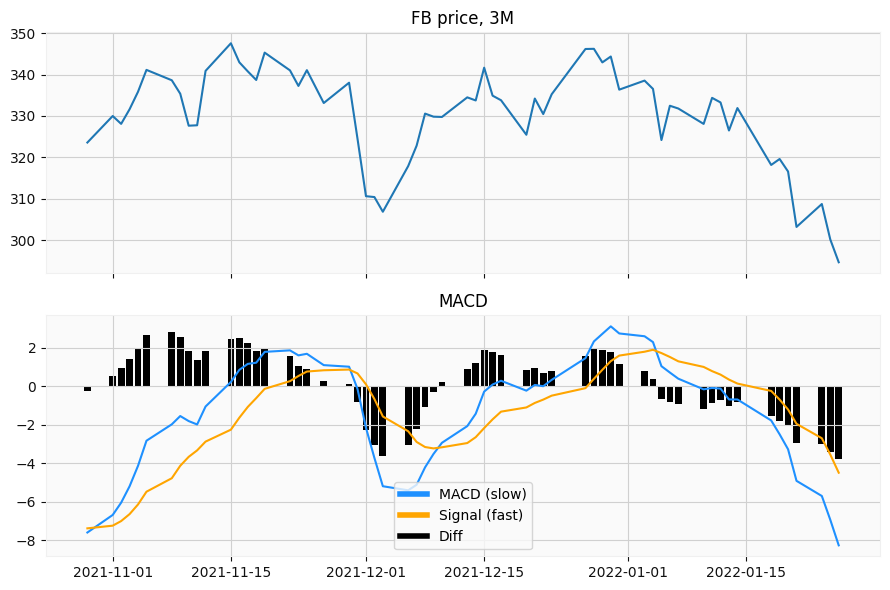

In [33]:
plot_macd("3M")